Here we visualize filters and outputs using the network architecture proposed by Krizhevsky et al. for ImageNet and implemented in `caffe`.

(This page follows DeCAF visualizations originally by Yangqing Jia.)

First, import required modules and set plotting parameters

In [1]:
import os, sys, os.path as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# this file is expected to be in ${CAFFE_ROOT}/examples
sys.path.insert(0, op.join(os.getenv('CAFFE_ROOT'), 'python'))

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

os.chdir(os.getenv('CITY_PATH'))
assert op.exists('data/cnn/lists/angles-train.txt')

Run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model, load the net, specify test phase and CPU mode, and configure input preprocessing.

In [2]:
caffe.set_mode_cpu()
net = caffe.Classifier(op.join(os.getenv('CITY_DATA_PATH'), 'cnn/architectures/color-deploy-py.prototxt'),
                       op.join(os.getenv('CITY_DATA_PATH'), 'cnn/models/color_iter_20000.caffemodel'))
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
net.transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
net.transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Run a classification pass

In [3]:
patch_path = op.join(os.getenv('CITY_PATH'), 'src/cnn/testdata/sedan-40x30.png')
scores = net.predict([caffe.io.load_image(patch_path)])

The layer features and their shapes (10 is the batch size, corresponding to the the ten subcrops used by Krizhevsky et al.)

In [4]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 30, 40)),
 ('conv1', (1, 64, 30, 40)),
 ('pool1', (1, 64, 15, 20)),
 ('conv2', (1, 64, 15, 20)),
 ('pool2', (1, 64, 7, 10)),
 ('conv3', (1, 128, 7, 10)),
 ('pool3', (1, 128, 3, 5)),
 ('ip1', (1, 3072, 1, 1)),
 ('ip2', (1, 2048, 1, 1)),
 ('ip3', (1, 2, 1, 1)),
 ('prob', (1, 2, 1, 1)),
 ('output', (1, 1, 1, 1))]

The parameters and their shapes (each of these layers also has biases which are omitted here)

In [5]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (64, 3, 5, 5)),
 ('conv2', (64, 64, 5, 5)),
 ('conv3', (128, 64, 5, 5)),
 ('ip1', (1, 1, 3072, 1920)),
 ('ip2', (1, 1, 2048, 3072)),
 ('ip3', (1, 1, 2, 2048))]

Helper functions for visualization

In [6]:
# take an array of shape (n, height, width) or (n, height, width, channels)
#  and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The input image

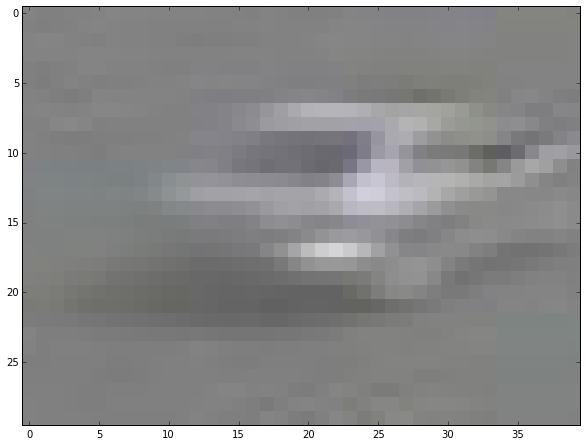

In [7]:
# index four is the center crop
plt.imshow(net.transformer.deprocess('data', net.blobs['data'].data[0]))

The first layer filters, `conv1`

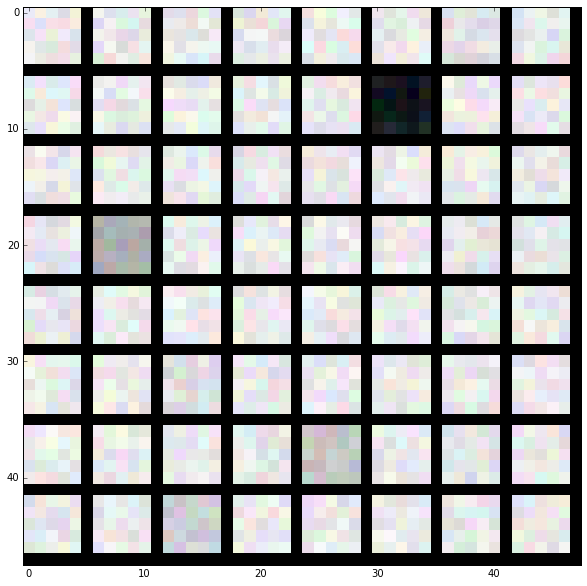

In [8]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

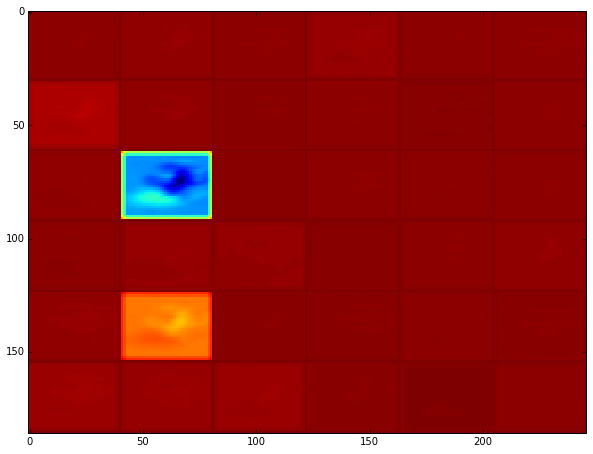

In [9]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

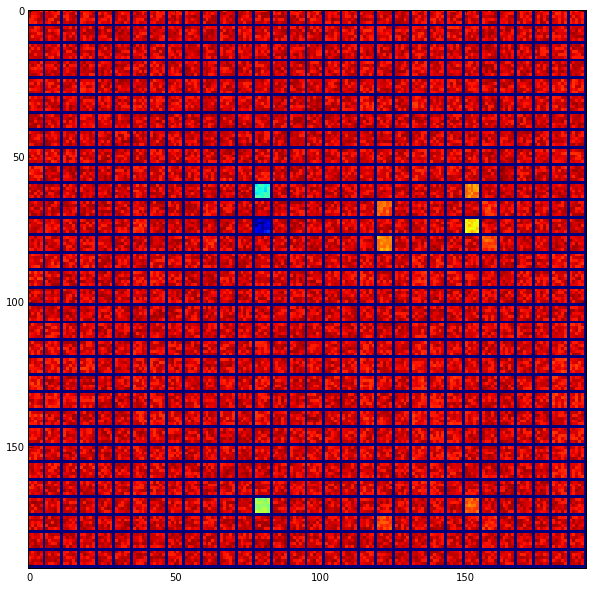

In [10]:
filters = net.params['conv2'][0].data
nCh = filters.shape[1]   # number of channels in a filter
nFilt = 16               # number of filters to draw
vis_square(filters[:nFilt].reshape(nFilt * nCh, 5, 5))

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

In [ ]:
feat = net.blobs['conv2'].data[0, :16]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

In [ ]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The third layer after pooling, `pool3`

In [ ]:
feat = net.blobs['pool3'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `ip1` (rectified)

We show the output values and the histogram of the positive values

In [ ]:
feat = net.blobs['ip1'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The second fully connected layer, `ip2` (rectified)

In [ ]:
feat = net.blobs['ip2'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, `prob`

In [ ]:
feat = net.blobs['prob'].data
plt.plot(feat.flat)